In [1]:
#Import relevant python packages
import os
import pandas as pd
import time
import numpy as np
import random
import requests
import tracemalloc
from sklearn.decomposition import PCA
from tqdm import tqdm
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import BallTree
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations
from collections import defaultdict

/Users/markandrawes/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## **Goodreads Dataset Procurement and Processing**
### Scraping and collecting data

In [2]:
class GoodreadsDataset:
    
    def __init__(self, save_path: Path, num_pages: int):
        self.save_path = save_path
        self.num_pages = num_pages
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
        }
        self.home_url = "https://www.goodreads.com"
        self.base_url = "https://www.goodreads.com/list/show/1.Best_Books_Ever?page="
        self.books_data = []

    @staticmethod
    def retrieve_genres(headers: dict, book_url: str):
        # Make a request to fetch the book page for the provided book url.
        response = requests.get(url=book_url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        # Identify genres using the HTML structure belonging to the genre category.
        genres = soup.select('a[href*="/genres/"]')
        return genres
    
    @staticmethod
    def to_csv(books_data: list, file_name: str):
        df = pd.DataFrame(books_data)
        df.to_csv(file_name, index=False)
        
    @staticmethod
    def scrape_bookpage(books_data: list, headers: dict, base_url: str, home_url: str, page: int):
        # Formulate bookpage url. 
        url = base_url + str(page)
        # Make a request to fetch the page content.
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.content, 'html.parser')
        # Find all books within the page content. 
        books = soup.find_all('tr', itemtype="http://schema.org/Book")
        for book in books:
            try:
                title = book.find('a', class_="bookTitle")
                author = book.find('a', class_="authorName")
                rating = book.find('span', class_="minirating")
                book_url = home_url + title['href']
                genres = GoodreadsDataset.retrieve_genres(headers, book_url)
                # Remove leading and trailing whitespaces.
                title = title.text.strip()
                author = author.text.strip()
                rating = rating.text.strip()[:4]
                genres = [genre.text.strip() for genre in genres]
                # Construct dictionary to store fetched book data. 
                book_data = {
                    'Title': title,
                    'Author': author,
                    'Rating': rating,
                    'Genres': genres
                }
                books_data.append(book_data)
                # Implement a request delay, to ensure continous access to scraping API.
                time.sleep(2)
            except (AttributeError, ValueError):
                continue
        
        return books_data
    
    def main(self):

        filename = "goodreads_dataset.csv"
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

        filepath = os.path.join(self.save_path, filename)
        
        if not os.path.exists(filepath):
            for page in range(self.num_pages):
                print(f"Fetching books metadata from page {page}")
                books_data = self.scrape_bookpage(self.books_data, self.headers, self.base_url, self.home_url, page)
                self.books_data.extend(books_data)
                self.to_csv(self.books_data, filepath)
        else:
            print(f"Dataset CSV file already exists.")

In [2]:
filepath = os.path.join("./data", "goodreads_dataset.csv")

if not os.path.exists(filepath):
    dataset = GoodreadsDataset("./data", 10)
    dataset.main()

dataset_df = pd.read_csv(filepath)

In [3]:
dataset_df.head(10)

,Title,Author,Rating,Genres
0,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,4.34,"['Young Adult', 'Fiction', 'Fantasy', 'Science..."
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.50,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',..."
2,Pride and Prejudice,Jane Austen,4.29,"['Fiction', 'Historical Fiction', 'Historical'..."
3,To Kill a Mockingbird,Harper Lee,4.26,"['Fiction', 'Historical Fiction', 'School', 'L..."
4,The Book Thief,Markus Zusak,4.39,"['Historical Fiction', 'Fiction', 'Young Adult..."
5,"Twilight (The Twilight Saga, #1)",Stephenie Meyer,3.66,"['Fantasy', 'Young Adult', 'Romance', 'Fiction..."
6,Animal Farm,George Orwell,3.99,"['Fiction', 'Dystopia', 'Fantasy', 'School', '..."
7,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,J.R.R. Tolkien,4.61,"['Fantasy', 'Fiction', 'Classics', 'Adventure'..."
8,The Chronicles of Narnia (The Chronicles of Na...,C.S. Lewis,4.28,"['Fantasy', 'Classics', 'Fiction', 'Young Adul..."
9,The Fault in Our Stars,John Green,4.13,"['Young Adult', 'Fiction', 'Contemporary', 'Re..."


### Cleaning and preprocessing of data

In [4]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
from tqdm.auto import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

class DataPreprocessor:
    def __init__(self, df):
        self.df = df.copy() 
        self.train_data = None
        self.test_data = None
        self.total_steps = 5 
        self.current_step = 0
    
    def _update_progress(self, description):
        """Update the overall progress and display current step"""
        self.current_step += 1
        print(f"\nStep {self.current_step}/{self.total_steps}: {description}")
    
    def clean_data(self):
        print("Starting data preprocessing pipeline...")
        self._update_progress("Checking initial data")
        print(f"Initial shape: {self.df.shape}")
        
        # Remove rows with empty genres
        self._update_progress("Removing empty genres")
        self.df = self.df.dropna(subset=['Genres'])
        print(f"Shape after removing empty genres: {self.df.shape}")
        
        # Clean and convert ratings
        self._update_progress("Cleaning ratings")
        self._clean_ratings()
        print(f"Shape after cleaning ratings: {self.df.shape}")
        
        # Filter non-English titles
        self._update_progress("Filtering non-English titles")
        self._filter_english_titles()
        print(f"Shape after filtering non-English titles: {self.df.shape}")
        
        # Convert genres and final cleanup
        self._update_progress("Processing genres and final cleanup")
        # Convert genres from string to list if they're strings
        if self.df['Genres'].dtype == 'object':
            tqdm.pandas(desc="Converting genres to lists")
            self.df['Genres'] = self.df['Genres'].progress_apply(self._convert_genres_to_list)
        
        # Remove books with empty genre lists
        self.df = self.df[self.df['Genres'].map(len) > 0]
        print(f"Final shape: {self.df.shape}")
        
        print("\nData preprocessing completed!")
        return self.df
    
    def _filter_english_titles(self):
        def is_english(text):
            try:
                return detect(str(text)) == 'en'
            except LangDetectException:
                return False
        
        # Create a progress bar for language detection
        tqdm.pandas(desc="Detecting languages")
        english_mask = self.df['Title'].progress_apply(is_english)
        
        # Store the number of non-English titles for reporting
        non_english_count = (~english_mask).sum()
        
        # Apply the filter
        self.df = self.df[english_mask]
        print(f"Removed {non_english_count} non-English titles")
    
    def _clean_ratings(self):
        def convert_rating(rating):
            try:
                if isinstance(rating, str):
                    rating = ''.join(c for c in rating if c.isdigit() or c == '.')
                return float(rating)
            except:
                return None
        
        # Convert ratings with progress bar
        tqdm.pandas(desc="Converting ratings")
        self.df['Rating'] = self.df['Rating'].progress_apply(convert_rating)
        
        # Remove rows with invalid ratings
        self.df = self.df.dropna(subset=['Rating'])
        
        # Ensure ratings are within valid range (0-5)
        self.df = self.df[self.df['Rating'].between(0, 5)]
    
    def _convert_genres_to_list(self, genres_str):
        if isinstance(genres_str, list):
            return genres_str
        try:
            genres_str = genres_str.strip('[]')
            genres = [g.strip().strip("'").strip('"') for g in genres_str.split(',')]
            return [g for g in genres if g]  # Remove empty strings
        except:
            return []
    
    def create_train_test_split(self, test_size=0.2, random_state=42):
        print("\nCreating train-test split...")
        self.train_data, self.test_data = train_test_split(
            self.df,
            test_size=test_size,
            random_state=random_state
        )
        
        print(f"Training set size: {len(self.train_data)}")
        print(f"Test set size: {len(self.test_data)}")
        
        return self.train_data, self.test_data
    
    def get_genre_statistics(self):
        print("\nCalculating genre statistics...")
        all_genres = []
        for genres in tqdm(self.df['Genres'], desc="Analyzing genres"):
            all_genres.extend(genres)
        
        genre_counts = pd.Series(all_genres).value_counts()
        
        print("\nGenre Statistics:")
        print(f"Total unique genres: {len(genre_counts)}")
        print("\nTop 10 most common genres:")
        print(genre_counts.head(10))
        
        return genre_counts

/Users/markandrawes/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Apply preprocessing
preprocessor = DataPreprocessor(dataset_df)
cleaned_df = preprocessor.clean_data()

# Create train-test split
train_data, test_data = preprocessor.create_train_test_split()

# Display data info
print("\nDataset info after cleaning:")
print(cleaned_df.info())

# Display some statistics
print("\nRating statistics:")
print(cleaned_df['Rating'].describe())

# Get genre statistics
genre_stats = preprocessor.get_genre_statistics()

# Create train-test split
train_data, test_data = preprocessor.create_train_test_split()

# Display sample of cleaned data
print("\nSample of cleaned data:")
print(cleaned_df.head(5))

Starting data preprocessing pipeline...

Step 1/5: Checking initial data
Initial shape: (204600, 4)

Step 2/5: Removing empty genres
Shape after removing empty genres: (204600, 4)

Step 3/5: Cleaning ratings


Converting ratings: 100%|██████████| 204600/204600 [00:00<00:00, 1110322.06it/s]


Shape after cleaning ratings: (200348, 4)

Step 4/5: Filtering non-English titles


Detecting languages: 100%|██████████| 200348/200348 [09:19<00:00, 358.06it/s]


Removed 46900 non-English titles
Shape after filtering non-English titles: (153448, 4)

Step 5/5: Processing genres and final cleanup


Converting genres to lists: 100%|██████████| 153448/153448 [00:00<00:00, 334619.72it/s]


Final shape: (152294, 4)

Data preprocessing completed!

Creating train-test split...
Training set size: 121835
Test set size: 30459

Dataset info after cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 152294 entries, 1 to 204599
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Title   152294 non-null  object 
 1   Author  152294 non-null  object 
 2   Rating  152294 non-null  float64
 3   Genres  152294 non-null  object 
dtypes: float64(1), object(3)
memory usage: 5.8+ MB
None

Rating statistics:
count    152294.000000
mean          4.159668
std           0.229677
min           3.290000
25%           4.010000
50%           4.160000
75%           4.310000
max           4.810000
Name: Rating, dtype: float64

Calculating genre statistics...


Analyzing genres: 100%|██████████| 152294/152294 [00:00<00:00, 5008368.62it/s]


Genre Statistics:
Total unique genres: 234

Top 10 most common genres:
Fiction               146797
Classics               86992
Fantasy                67560
Young Adult            60909
Literature             51546
Historical Fiction     51098
Novels                 39221
Audiobook              31124
Historical             29614
Childrens              29486
Name: count, dtype: int64

Creating train-test split...
Training set size: 121835
Test set size: 30459

Sample of cleaned data:
                                               Title           Author  Rating  \
1  Harry Potter and the Order of the Phoenix (Har...     J.K. Rowling    4.50   
3                              To Kill a Mockingbird       Harper Lee    4.26   
4                                     The Book Thief     Markus Zusak    4.39   
5                   Twilight (The Twilight Saga, #1)  Stephenie Meyer    3.66   
7  J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...   J.R.R. Tolkien    4.61   

                       

## **Frequent itemset algorithms**

### Apriori Algorithm

In [7]:
class Apriori:
    def __init__(self, df: pd.DataFrame, min_support: float):
        self.df = df
        self.min_support = min_support
        self.frequent_itemsets = []
        self.genres_df = self.df['Genres']
        self.df = self.one_hot_encode(self.genres_df)

    @staticmethod
    def one_hot_encode(genres_df: pd.DataFrame):
        one_hot_encoded = genres_df.apply(lambda x: pd.Series(1, index=x)).fillna(0)
        return one_hot_encoded

    @staticmethod
    def retrieve_singletons(df: pd.DataFrame):
        return df.sum(axis=0).to_dict()

    @staticmethod
    def set_of_candidates(itemsets: list[tuple], k: int):
        candidates = set()
        for i in range(len(itemsets)):
            for j in range(i + 1, len(itemsets)):
                ith_itemset = itemsets[i]
                jth_itemset = itemsets[j]
                candidate = tuple(sorted(set(ith_itemset).union(set(jth_itemset))))
                if len(candidate) == k:
                    candidates.add(candidate)
        return list(candidates)

    @staticmethod
    def compute_support(df: pd.DataFrame, itemset: tuple):
        count = df[list(itemset)].all(axis=1).sum() if all(genre in df.columns for genre in itemset) else 0
        support = count / len(df)
        return support
    
    def run_apriori(self, min_confidence: float):

        freq_itemsets = {}
        frequent_1_itemsets = []
    
        # Generate 1-itemsets
        singletons = self.retrieve_singletons(self.df)
        k = 1

        for genre, count in singletons.items():
            support = count / len(self.df)
            if support >= self.min_support:
                self.frequent_itemsets.append({'support': support, 'itemsets': (genre,)})
                frequent_1_itemsets.append((genre,))
        
        freq_itemsets[k] = frequent_1_itemsets
            
        # Generate k-itemsets
        k = 2
        while True:
            candidates = self.set_of_candidates(freq_itemsets[k - 1], k)
            frequent_k_itemsets = []
            frequent_itemsets = []
            for candidate in candidates:
                support = self.compute_support(self.df, candidate)
                if support >= self.min_support:
                    frequent_itemsets.append({'support': support, 'itemsets': (candidate)})
                    frequent_k_itemsets.append(candidate)
            if not frequent_itemsets:
                break
            else:
                freq_itemsets[k] = frequent_k_itemsets
                k += 1
                self.frequent_itemsets.extend(frequent_itemsets)

            

        rules = association_rules(df=pd.DataFrame(self.frequent_itemsets), min_threshold=min_confidence)

        return pd.DataFrame(self.frequent_itemsets), pd.DataFrame(rules)

#### Testing Apriori implementation

In [8]:
# Initialize the A-Priori class.
apriori_custom = Apriori(train_data, min_support=0.05)

# Perform the A-Priori algorithm to generate frequent itemsets and assocation rules. 
frequent_itemsets_apriori, apriori_rules = apriori_custom.run_apriori(min_confidence=0.7)

# Perform the A-Priori algorithm using another python package.
frequent_itemsets = apriori(apriori_custom.df, min_support=0.05, use_colnames=True)

/Users/albertmoller/anaconda3/envs/datascience/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [9]:
print("\nSample of frequent itemsets")
print(frequent_itemsets_apriori.head(5))
print("\nSample of frequent itemsets obtained using mlxtend")
print(frequent_itemsets.head(5))
print("\nSample of association rules")
print(apriori_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5))



Sample of frequent itemsets
    support       itemsets
0  0.558328    (Classics,)
1  0.968237     (Fiction,)
2  0.452847     (Fantasy,)
3  0.179179   (Childrens,)
4  0.053614  (Philosophy,)

Sample of frequent itemsets obtained using mlxtend
    support      itemsets
0  0.558328    (Classics)
1  0.968237     (Fiction)
2  0.452847     (Fantasy)
3  0.179179   (Childrens)
4  0.053614  (Philosophy)

Sample of association rules
    antecedents           consequents   support  confidence      lift
0       (Crime)             (Fiction)  0.054125    0.972562  1.004468
1     (Romance)             (Fiction)  0.164881    0.946913  0.977977
2   (Adventure)             (Fantasy)  0.113829    0.717268  1.583907
3   (Audiobook)             (Fiction)  0.201427    0.987258  1.019646
4  (Historical)  (Historical Fiction)  0.190492    0.986215  2.992461


### PCY Algorithm

In [10]:
class PCY:
    def __init__(self, df, min_support, hash_size=10):
        self.df = df
        self.min_support = min_support
        self.hash_size = hash_size
        self.freq_itemsets = []
        self.genres_df = self.df['Genres']
        self.df = self.one_hot_encode(self.genres_df)  # One-hot encode genres for transaction format
        self.transactions = self.df_to_transactions() 
        self.num_transactions = len(self.transactions)

    @staticmethod
    def one_hot_encode(genres_df):
        one_hot_encoded = genres_df.apply(lambda x: pd.Series(1, index=x)).fillna(0)
        return one_hot_encoded

    def df_to_transactions(self):
        # Convert one-hot encoded df to list of transactions
        transactions = []
        for _, row in self.df.iterrows():
            transaction = row.index[row == 1].tolist() 
            transactions.append(transaction)
        return transactions

    def filter_freq_items(self, item_count):
        # Filters based on minimum support threshold
        freq_items = set()
        for item, count in item_count.items():
            if count / self.num_transactions >= self.min_support:
                freq_items.add(item)

        return freq_items
    
    def filter_freq_buckets_to_bitmap(self, hash_table):
        # Converts frequent buckets into a bitmap
        bitmap = np.zeros(self.hash_size, dtype=bool)
        for i, count in enumerate(hash_table):
            if count / self.num_transactions >= self.min_support:
                bitmap[i] = True
        return bitmap
    
    def pass_one(self):
        # Count single items and hash item pairs into buckets
        item_count = defaultdict(int)
        hash_table = np.zeros(self.hash_size, dtype=int)

        for transaction in self.transactions:
            for item in transaction:
                item_count[item] += 1
            for item_pair in combinations(transaction, 2):
                hash_value = hash(frozenset(item_pair)) % self.hash_size  
                hash_table[hash_value] += 1

        return item_count, hash_table

    def pass_two(self, freq_items, bitmap):
        # Count pairs that are both frequent items and hashed to frequent buckets using the bitmap
        pair_count = defaultdict(int)

        for transaction in self.transactions:
            for item_pair in combinations(transaction, 2):
                if item_pair[0] in freq_items and item_pair[1] in freq_items:
                    hash_value = hash(frozenset(item_pair)) % self.hash_size
                    if bitmap[hash_value]:  
                        pair_count[item_pair] += 1

        freq_pairs = {}
        for pair, count in pair_count.items():
            support = count / self.num_transactions
            if support >= self.min_support:
                freq_pairs[pair] = count

        return freq_pairs

    def run_pcy(self, min_confidence: float):
        item_count, hash_table = self.pass_one()

        freq_items = self.filter_freq_items(item_count)

        # Only keep items that meet the minimum support threshold
        filtered_item_count = {item: count for item, count in item_count.items() if item in freq_items}

        bitmap = self.filter_freq_buckets_to_bitmap(hash_table)

        freq_pairs = self.pass_two(freq_items, bitmap)

        for item, count in filtered_item_count.items():
            support = count / self.num_transactions
            if support >= self.min_support:  
                itemset = {'support': support, 'itemsets': (item,)}
                self.freq_itemsets.append(itemset)

        for pair, count in freq_pairs.items():
            support = count / self.num_transactions
            itemset = {'support': support, 'itemsets': set(pair)}
            self.freq_itemsets.append(itemset)

        rules = association_rules(df=pd.DataFrame(self.freq_itemsets), min_threshold=min_confidence)

        return pd.DataFrame(self.freq_itemsets), pd.DataFrame(rules)


#### Testing PCY implementation

In [11]:
# Initialize the Apriori class.
pcy_custom = PCY(train_data, min_support=0.05)

# Perform the PCY algorithm to generate frequent itemsets and assocation rules. 
frequent_itemsets_pcy, pcy_rules = pcy_custom.run_pcy(min_confidence=0.7)

In [12]:
print("\nSample of frequent itemsets")
print(frequent_itemsets_pcy.head(5))
print("\nSample of association rules")
print(pcy_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5))



Sample of frequent itemsets
    support       itemsets
0  0.558328    (Classics,)
1  0.968237     (Fiction,)
2  0.452847     (Fantasy,)
3  0.179179   (Childrens,)
4  0.053614  (Philosophy,)

Sample of association rules
     antecedents consequents   support  confidence      lift
0     (Classics)   (Fiction)  0.542351    0.971385  1.003252
1      (Fantasy)   (Fiction)  0.444417    0.981385  1.013580
2    (Childrens)   (Fiction)  0.179179    1.000000  1.032805
3   (Philosophy)   (Fiction)  0.050049    0.933506  0.964130
4  (Young Adult)   (Fiction)  0.369091    0.980078  1.012230


In [13]:
# only package of a black-box PCY I could find to compare with but I can't currently get it to run.
# however, it does give the same result as A-Priori

# import pyfim 

# result = pyfim.pcy(df, min_support=2)
# print(result)

#### Quantifying algorithmic performance of A-priori and PCY

In [14]:
class FrequentItemsPerformance:
    
    def __init__(self, apriori: Apriori, pcy: PCY):
        
        self.apriori = apriori
        self.pcy = pcy

    @staticmethod
    def time(func: callable, *args):
        start = time.time()
        result = func(*args)
        end = time.time()
        time_taken = end - start
        return result, time_taken
    
    @staticmethod
    def patterns(result: tuple):
        frequent_itemsets, rules = result
        return len(frequent_itemsets), len(rules)
    
    @staticmethod
    def memory(func: callable, *args):
        tracemalloc.start()
        result = func(*args)
        size, peak_size = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        return result, peak_size
    
    def compare_algorithms(self, df: pd.DataFrame, min_confidence: float):
        # Intiailize an empty list to store performance results.
        apriori_results = []
        pcy_results = []

        for min_support in tqdm([0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]):

            # Compute performance metrics using A-priori
            apriori_instance = self.apriori(df, min_support)
            apriori_result, apriori_time = self.time(apriori_instance.run_apriori, min_confidence)
            apriori_instance = self.apriori(df, min_support)
            _, apriori_memory = self.memory(apriori_instance.run_apriori, min_confidence)
            apriori_num_freqitems, apriori_num_rules = self.patterns(apriori_result)

            # Compute performance metrics using PCY
            pcy_instance = self.pcy(df, min_support)
            pcy_result, pcy_time = self.time(pcy_instance.run_pcy, min_confidence)
            pcy_instance = self.pcy(df, min_support)
            _, pcy_memory = self.memory(pcy_instance.run_pcy, min_confidence)
            pcy_num_freqitems, pcy_num_rules = self.patterns(pcy_result)
        
            # Save results
            apriori_results.append({
                "Support": min_support,
                "Time (seconds)": apriori_time,
                "Memory (KB)": apriori_memory / 1024,
                "Frequent Items Found": apriori_num_freqitems,
                "Association rules Found": apriori_num_rules
            })
            pcy_results.append({
                "Support": min_support,
                "Time (seconds)": pcy_time,
                "Memory (KB)": pcy_memory / 1024,
                "Frequent Items Found": pcy_num_freqitems,
                "Association rules Found": pcy_num_rules
            })

        return pd.DataFrame(apriori_results), pd.DataFrame(pcy_results)

In [15]:
apriori_custom = Apriori
pcy_custom = PCY

performance = FrequentItemsPerformance(apriori_custom, pcy_custom)
apriori_results, pcy_results = performance.compare_algorithms(df=train_data, min_confidence=0.7)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [10:05<00:00, 60.60s/it]


In [28]:
# Display performance results
apriori_results.head(10)


,Support,Time (seconds),Memory (KB),Frequent Items Found,Association rules Found
0,0.01,19.196398,37743.214844,2489,8916
1,0.05,1.051119,37743.214844,237,339
2,0.10,0.260348,37743.214844,79,81
3,0.15,0.172740,37743.214844,47,35
4,0.20,0.075864,37743.214844,23,14
5,0.25,0.065889,37743.214844,13,6
6,0.30,0.062684,37743.214844,11,5
7,0.40,0.045668,37743.214844,5,2
8,0.50,0.042923,37743.214844,3,1
9,0.60,0.045264,37743.214844,1,0


In [27]:
# Display performance results
pcy_results.head(10)

,Support,Time (seconds),Memory (KB),Frequent Items Found,Association rules Found
0,0.01,1.632416,573.144531,490,197
1,0.05,1.411254,125.726562,107,42
2,0.10,1.315522,71.703125,48,21
3,0.15,1.276940,61.695312,36,16
4,0.20,1.146889,49.085938,19,8
5,0.25,1.127655,44.273438,13,6
6,0.30,1.095074,42.875000,11,5
7,0.40,1.020488,38.328125,5,2
8,0.50,0.986321,36.523438,3,1
9,0.60,0.960839,27.284180,1,0


## **Clustering**

### K-Means Clustering

In [6]:
class KMeansClustering:
    def __init__(self, df, n_clusters=3, random_state=42):
        self.df = df.copy()
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.genre_to_index = {}
        self.all_genres = []
        self.feature_matrix = None
        self.custom_labels = None
        self.sklearn_labels = None
        self.custom_centroids = None
        self.sklearn_centroids = None
        self.X_pca = None

    def prepare_data(self):
        # Get all unique genres
        all_genres = set()
        for genres in self.df['Genres']:
            all_genres.update(genres)
        self.all_genres = sorted(all_genres)
        
        # Create a mapping from genre to index
        self.genre_to_index = {genre: idx for idx, genre in enumerate(self.all_genres)}
        
        # Convert genres to one-hot encoded vectors
        self.df['Genre_Vector'] = self.df['Genres'].apply(self._genres_to_onehot)
        
        # Scale the Rating feature
        scaler = StandardScaler()
        self.df['Scaled_Rating'] = scaler.fit_transform(self.df[['Rating']])
        
        # Combine Genre_Vector and Scaled_Rating into a single feature vector
        feature_vectors = np.stack(self.df['Genre_Vector'].values)
        ratings = self.df['Scaled_Rating'].values.reshape(-1, 1)
        self.feature_matrix = np.hstack((feature_vectors, ratings))

    def _genres_to_onehot(self, genres_list):
        vector = np.zeros(len(self.all_genres))
        for genre in genres_list:
            idx = self.genre_to_index.get(genre)
            if idx is not None:
                vector[idx] = 1
        return vector

    def fit_custom_kmeans(self):
        # Implement K-means clustering
        np.random.seed(self.random_state)
        initial_centroid_indices = np.random.choice(len(self.feature_matrix), self.n_clusters, replace=False)
        self.custom_centroids = self.feature_matrix[initial_centroid_indices]
        
        for iteration in range(300):  # max_iter=300
            # Assign clusters
            distances = self._compute_distances(self.feature_matrix, self.custom_centroids)
            labels = np.argmin(distances, axis=1)
            # Update centroids
            new_centroids = np.zeros_like(self.custom_centroids)
            for k in range(self.n_clusters):
                cluster_points = self.feature_matrix[labels == k]
                if len(cluster_points) > 0:
                    new_centroids[k] = cluster_points.mean(axis=0)
                else:
                    # Reinitialize centroid if cluster is empty
                    new_centroids[k] = self.feature_matrix[np.random.choice(len(self.feature_matrix))]
            # Check for convergence
            if np.allclose(self.custom_centroids, new_centroids, atol=1e-4):
                break
            self.custom_centroids = new_centroids
        self.custom_labels = labels

    def fit_sklearn_kmeans(self):
        kmeans = KMeans(
            n_clusters=self.n_clusters,
            init=self.custom_centroids,
            n_init=1,
            max_iter=300,
            tol=1e-4,
            algorithm='lloyd', 
            random_state=self.random_state
        )
        kmeans.fit(self.feature_matrix)
        self.sklearn_labels = kmeans.labels_
        self.sklearn_centroids = kmeans.cluster_centers_

    def _compute_distances(self, X, centroids):
        return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

    def calculate_davies_bouldin_index(self, labels, centroids):
        n_clusters = len(centroids)
        cluster_k = [self.feature_matrix[labels == k] for k in range(n_clusters)]
        s = [np.mean(np.linalg.norm(cluster - centroids[i], axis=1)) for i, cluster in enumerate(cluster_k)]
        db_index = 0
        for i in range(n_clusters):
            max_ratio = max(
                [(s[i] + s[j]) / np.linalg.norm(centroids[i] - centroids[j]) 
                 for j in range(n_clusters) if j != i]
            )
            db_index += max_ratio
        db_index /= n_clusters
        return db_index

    def visualize_clusters(self, labels, title):
        # Reduce dimensions to 2D using PCA
        pca = PCA(n_components=2)
        self.X_pca = pca.fit_transform(self.feature_matrix)
        
        # Plotting
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(self.X_pca[:, 0], self.X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
        plt.legend(*scatter.legend_elements(), title="Clusters")
        plt.title(title)
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.show()

    def run_all(self):
        # Prepare data
        self.prepare_data()
        print("Data preparation complete.")
        
        # Fit custom KMeans
        self.fit_custom_kmeans()
        print("Custom KMeans clustering complete.")
        
        # Fit sklearn KMeans
        self.fit_sklearn_kmeans()
        print("sklearn KMeans clustering complete.")
        
        # Calculate Davies-Bouldin Index for custom KMeans
        db_index_custom = self.calculate_davies_bouldin_index(self.custom_labels, self.custom_centroids)
        print("Davies-Bouldin Index (Custom KMeans):", db_index_custom)
        
        # Calculate Davies-Bouldin Index for sklearn KMeans
        db_index_sklearn = self.calculate_davies_bouldin_index(self.sklearn_labels, self.sklearn_centroids)
        print("Davies-Bouldin Index (sklearn KMeans):", db_index_sklearn)
        
        # Visualize clusters for custom KMeans
        self.visualize_clusters(self.custom_labels, "Clusters from Custom KMeans")
        
        # Visualize clusters for sklearn KMeans
        self.visualize_clusters(self.sklearn_labels, "Clusters from sklearn KMeans")


Data preparation complete.
Custom KMeans clustering complete.
sklearn KMeans clustering complete.
Davies-Bouldin Index (Custom KMeans): 2.2719778552858294
Davies-Bouldin Index (sklearn KMeans): 2.2719778552858094


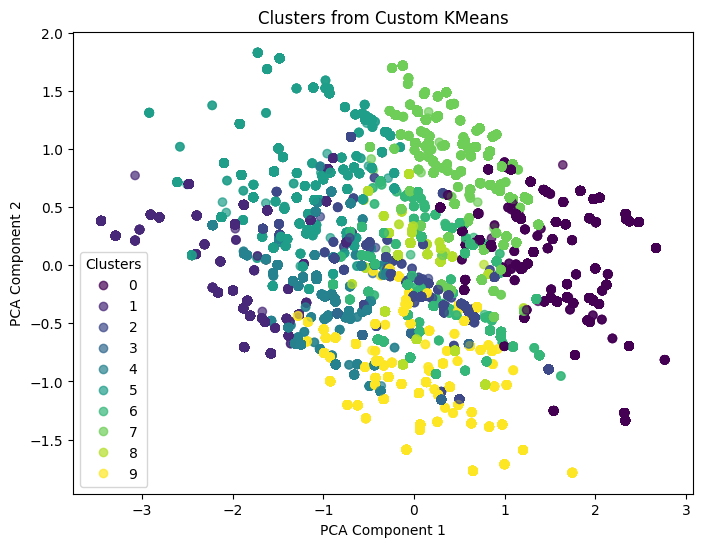

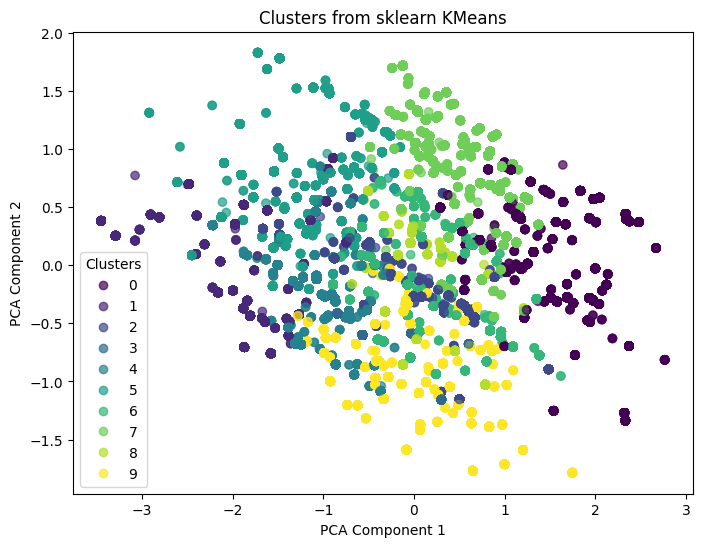

In [10]:
# Initialize the clustering class
clustering = KMeansClustering(train_data, n_clusters=10, random_state=42)

# Run all steps
clustering.run_all()


## **Recommendation System**

### Using frequent itemsets (Apriori/PCY)

In [20]:
from tqdm import tqdm

def recommend_with_frequent_itemsets(rules: pd.DataFrame, data: pd.DataFrame, algo_type: str):
    """Recommends a single book based on the genres of the input book using either A-Priori or PCY."""

    for row in tqdm(data.itertuples(index=True), total=len(data)): 
        genres = set(row.Genres)
        current_title = row.Title
        recommended_genres = set()
        # Find matching genres using association rule.
        for _, rule in rules.iterrows():
            antecedent = set(rule['antecedents'])
            consequent = set(rule['consequents'])
            if antecedent.issubset(set(genres)):
                recommended_genres.update(consequent)
        # Find books with matching genres.
        data['Intersection Size'] = data['Genres'].apply(lambda x: len(set(x) & set(recommended_genres)))
        recommended_books = data[(data['Title'] != current_title) &  (data['Intersection Size'] > 0)].sort_values(by='Intersection Size', ascending=False)
        if recommended_books.empty:
            data.at[row.Index, f'{algo_type} Recommendations'] = f"No recommendation found for book with title {current_title}"
        else:
            top_recommendation = recommended_books.sort_values(by=['Intersection Size', 'Rating'], ascending=False)['Title'].iloc[0]
            data.at[row.Index, f'{algo_type} Recommendations'] = top_recommendation
        data.drop(columns=['Intersection Size'], inplace=True)

In [21]:
# Ensure titles are unique. 
unique_titles = test_data.drop_duplicates(subset='Title')
# Ensure genres are unique. 
unique_genres = unique_titles.drop_duplicates(subset='Genres')
# Randomly sample 100 for recommendations. 
sampled_data = unique_genres.sample(n=100, random_state=42) 
# Find book recommendations using A-Priori.
recommend_with_frequent_itemsets(apriori_rules, sampled_data, "A-Priori")
# Find book recommendations using PCY.
recommend_with_frequent_itemsets(pcy_rules, sampled_data, "PCY")


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 898.49it/s]


In [22]:
sampled_data.head(10)

,Title,Author,Rating,Genres,A-Priori Recommendations,PCY Recommendations
133965,Franny and Zooey,J.D. Salinger,3.96,"[Fiction, Short Stories, Literature, Classics,...","The Hobbit (The Lord of the Rings, #0)","The Hobbit (The Lord of the Rings, #0)"
54147,Do Androids Dream of Electric Sheep?,Philip K. Dick,4.09,"[Science Fiction, Dystopia, Cyberpunk, Science...",Animal Farm,Animal Farm
40697,Don Quixote,Miguel de Cervantes Saavedra,3.90,"[Fiction, Classics, Literature, Spanish Litera...","The Hobbit (The Lord of the Rings, #0)","The Hobbit (The Lord of the Rings, #0)"
196100,The Neverending Story,Michael Ende,4.18,"[Fantasy, Classics, Fiction, Young Adult, Chil...",Harry Potter and the Prisoner of Azkaban (Harr...,Harry Potter and the Prisoner of Azkaban (Harr...
119558,Girl with a Pearl Earring,Tracy Chevalier,3.93,"[Historical Fiction, Fiction, Historical, Clas...","The Godfather (The Godfather, #1)","The Godfather (The Godfather, #1)"
173726,"The Lion, the Witch and the Wardrobe (Chronicl...",C.S. Lewis,4.24,"[Fantasy, Fiction, Young Adult, Childrens, Cla...",Harry Potter and the Prisoner of Azkaban (Harr...,Harry Potter and the Prisoner of Azkaban (Harr...
72946,All Quiet on the Western Front,Erich Maria Remarque,4.08,"[Fiction, Historical Fiction, War, Classics, H...",Little Women,Little Women
178786,"Perfect Chemistry (Perfect Chemistry, #1)",Simone Elkeles,4.04,"[Romance, Young Adult, Contemporary, High Scho...",Harry Potter and the Prisoner of Azkaban (Harr...,"Kingdom of Ash (Throne of Glass, #7)"
124388,"The House of Hades (The Heroes of Olympus, #4)",Rick Riordan,4.57,"[Fantasy, Mythology, Young Adult, Middle Grade...",Harry Potter and the Prisoner of Azkaban (Harr...,Harry Potter and the Prisoner of Azkaban (Harr...
162230,The Hitchhiker’s Guide to the Galaxy (Hitchhik...,Douglas Adams,4.23,"[Science Fiction, Fiction, Humor, Fantasy, Com...",Harry Potter and the Prisoner of Azkaban (Harr...,Harry Potter and the Prisoner of Azkaban (Harr...


### Using clusters (K-means/DBSCAN)

In [11]:
def recommend_with_clustering(train_data: pd.DataFrame, test_data: pd.DataFrame, algo_type: str):
    """Recommends a single book based on the genres of the input book using K-Means clustering."""

    def genres_to_onehot(genres_list, all_genres, genre_to_index):
        vector = np.zeros(len(all_genres))
        for genre in genres_list:
            idx = genre_to_index.get(genre)
            if idx is not None:
                vector[idx] = 1
        return vector

    # Get all unique genres from both train and test data.
    all_genres = set()
    for genres in train_data['Genres']:
        all_genres.update(genres)
    for genres in test_data['Genres']:
        all_genres.update(genres)
    all_genres = sorted(all_genres)

    genre_to_index = {genre: idx for idx, genre in enumerate(all_genres)}

    # Create one-hot encoded genre vectors.
    train_data['Genre_Vector'] = train_data['Genres'].apply(lambda x: genres_to_onehot(x, all_genres, genre_to_index))
    test_data['Genre_Vector'] = test_data['Genres'].apply(lambda x: genres_to_onehot(x, all_genres, genre_to_index))

    if algo_type == "K-Means":
        clustering_model = KMeans(
            n_clusters=100,
            n_init=1,
            max_iter=300,
            tol=1e-4,
            algorithm='lloyd', 
            random_state=42
        )

    # Assign clusters to the training data.
    train_data['Cluster'] = clustering_model.fit_predict(np.vstack(train_data['Genre_Vector'].values))

    # Predict clusters for the test data.
    test_data['Cluster'] = clustering_model.fit_predict(np.vstack(test_data['Genre_Vector'].values))

    # Compute recommendation
    test_data[f'{algo_type} Recommendations'] = None
    for idx, row in test_data.iterrows():
        current_cluster = row['Cluster']
        current_title = row['Title']
        
        cluster_books = train_data[train_data['Cluster'] == current_cluster]
        recommendations = cluster_books[cluster_books['Title'] != current_title]
        
        top_recommendation = recommendations.sort_values(by='Rating', ascending=False)['Title'].iloc[0]

        if top_recommendation:
            test_data.at[idx, f'{algo_type} Recommendations'] = top_recommendation
        else:
            test_data.at[idx, f'{algo_type} Recommendations'] = "No recommendations found"

    train_data.drop(columns=['Cluster'], inplace=True)
    test_data.drop(columns=['Cluster'], inplace=True)
    train_data.drop(columns=['Genre_Vector'], inplace=True)
    test_data.drop(columns=['Genre_Vector'], inplace=True)

In [12]:
# Ensure titles are unique. 
unique_titles = test_data.drop_duplicates(subset='Title')
# Ensure genres are unique. 
unique_genres = unique_titles.drop_duplicates(subset='Genres')
# Randomly sample 100 for recommendations. 
sampled_data = unique_genres.sample(n=100, random_state=42) 
# Find book recommendations using A-Priori.
recommend_with_clustering(train_data, sampled_data, "K-Means")

/Users/markandrawes/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (99) found smaller than n_clusters (100). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [15]:
sampled_data.head(50)

,Title,Author,Rating,Genres,K-Means Recommendations
166093,"Halfway to the Grave (Night Huntress, #1)",Jeaniene Frost,4.13,"[Paranormal, Vampires, Urban Fantasy, Romance,...",The Grapes of Wrath
164675,"Watership Down (Watership Down, #1)",Richard Adams,4.09,"[Classics, Fiction, Fantasy, Young Adult, Anim...",Harry Potter and the Deathly Hallows (Harry Po...
204214,A Christmas Carol,Charles Dickens,4.08,"[Fiction, Christmas, Classics, Fantasy, Audiob...",A Court of Mist and Fury (A Court of Thorns an...
153272,"Wicked Lovely (Wicked Lovely, #1)",Melissa Marr,3.70,"[Fantasy, Young Adult, Romance, Urban Fantasy,...","Night Watch (Discworld, #29; City Watch, #6)"
204510,The Witch of Blackbird Pond,Elizabeth George Speare,4.02,"[Historical Fiction, Young Adult, Fiction, Cla...","The Little House Collection (Little House, #1-9)"
38099,"Neuromancer (Sprawl, #1)",William Gibson,3.89,"[Science Fiction, Fiction, Cyberpunk, Classics...",A Thousand Splendid Suns
204376,"Guards! Guards! (Discworld, #8; City Watch, #1)",Terry Pratchett,4.34,"[Fantasy, Fiction, Humor, Comedy, Audiobook, D...",The Secret History
180656,Where the Wild Things Are,Maurice Sendak,4.25,"[Picture Books, Childrens, Fiction, Classics, ...",The Master and Margarita
110743,The Divine Comedy,Dante Alighieri,4.08,"[Poetry, Fiction, Literature, Philosophy, Fant...",Pride and Prejudice
22081,A Good Girl's Guide to Murder (A Good Girl's G...,Holly Jackson,4.31,"[Young Adult, Thriller, Mystery Thriller, Fict...",The Addiction Manifesto


### Combine both approaches

## **Evaluation and Metrics**